# Unsupervised learning: PCA and clustering

## 0. Introduction

The main difference between unsupervised learning methods and the usual classifications and regressions is that there is no known correct answer in the data in this case. Several features are formed at once. At first, it is the possible of using incomparably large amounts of data, since they will not need to be marked by hand for training. At the second, there are the ambiguity of measuring the quality of methods, due to the lack of the same straightforward and intuitive metrics, as in supervised learning tasks.

One of the most obvious tasks that arise in the head in the absence of explicit markup is the task of data dimensionality reduction. On the one hand, it can be considered as an aid in data visualization; for this, the t-SNE method is often used, which we discussed in the second article of the class. On the other hand, such dimensionality reduction can remove superfluous highly correlated features from observations and prepare data for further processing in supervised learning mode, for example, to make the input data more "digestible" for decision trees.

## 1. Principal Component Analysis (PCA)

### Intuition, theory and application features

Principal Component Analysis — one of the most intuitive and commonly used methods for data dimensionality reduction and projection onto an orthogonal feature subspace.

<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/450px-GaussianScatterPCA.svg.png" width="400">

In a very general way, this can be represented as the assumption that all our observations most likely look like some kind of ellipsoid in a subspace of our original space and our new basis in this space coincides with the axes of this ellipsoid. This assumption allows us to simultaneously get rid of highly correlated features, since the basis vectors of the space we are projecting onto will be orthogonal.

In the general case, the dimension of this ellipsoid will be equal to the dimension of the original space, but our assumption that the data lies in a subspace of a lower dimension allows us to discard the "extra" subspace in the new projection, namely the subspace along whose axes the ellipsoid will be the least stretched. We will do this "greedy", choosing in turn as a new element of the basis of our new subspace, successively the axis of the ellipsoid from the remaining ones, along which the dispersion will be maximum.

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton

Let's see how we can do it in math:

To reduce the dimension of our data from $n$ to $k, k \leq n$, we need to choose the top $k$ axes of such an ellipsoid, sorted in descending order by variance along the axes.

Let's start by calculating the variances and covariances of the original features. This is done simply by using the covariance matrix. By definition of covariance, for two features $X_i$ and $X_j$ their covariance will be$$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j$$
where $\mu_i$ is the expectation of the $i$th feature.

Note that the covariance is symmetric and the covariance of a vector with itself will be equal to its variance.

So, the covariance matrix is a symmetrical matrix, where the variances of the corresponding features lie on the diagonal, and the covariances of the corresponding pairs of features lie outside the diagonal. In matrix form, where $\mathbf{X}$ is the observation matrix, our covariance matrix will look like
$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Matrices as linear operators have such an interesting property as eigenvalues and eigenvectors (eigenvalues and eigenvectors). These things are remarkable in that when we act on the corresponding linear space with our matrix, the eigenvectors remain in place and are only multiplied by their corresponding eigenvalues. That is, they define a subspace that, when this matrix acts as a linear operator, remains in place or "transforms into itself". Formally, the eigenvector $w_i$ with eigenvalue $\lambda_i$ for the matrix $M$ is simply defined as $M w_i = \lambda_i w_i$.

The covariance matrix for our sample $\mathbf{X}$ can be represented as the product $\mathbf{X}^{T} \mathbf{X}$. It follows from the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient) that the maximum variation of our dataset will be along the eigenvector of this matrix corresponding to the maximum eigenvalue. Thus the principal components that we would like to project our data onto are simply the eigenvectors of the corresponding top-$k$ eigenvalues of this matrix.

The next steps are simple to disgrace - you just need to multiply our data matrix by these components and we will get the projection of our data in the orthogonal basis of these components. Now if we transpose our data matrix and principal component vector matrix, we restore the original sample in the space from which we projected onto the components. If the number of components was less than the dimension of the original space, we will lose some of the information during this transformation.

## Examples
### Iris dataset
Let's start by loading all the necessary modules and twisting the usual dataset with irises, following the example from the scikit-learn package documentation.

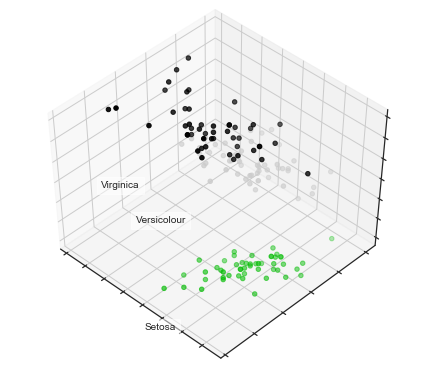

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# load data
iris = datasets.load_iris()
X = iris.data
y = iris.target


fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

y_clr = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Now let's see how much PCA improves the results for a model that in this case does a poor job of classifying due to the fact that it does not have enough complexity to describe the data:

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)


clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)


preds = clf.predict_proba(X_train)
print('Accuracy: {:.5f}'.format(accuracy_score(y_train, 
                                                preds.argmax(axis=1))))
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.97143
Accuracy: 0.88889


Now let's try to do the same, but with data for which we have reduced the dimension to 2D:

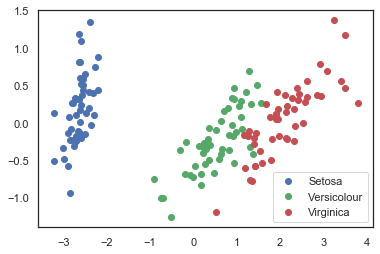

In [3]:
# Use sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Draw points in reduced space
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [4]:
# Do the same for train.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


It can be seen that the quality has increased slightly, but for more complex data of higher dimension, where the data is not trivially split along one feature, the use of PCA can significantly improve the quality of decision trees and ensembles based on them.

Let's look at the 2 principal components in the last PCA representation of the data and the percentage of the original variance in the data that they "explain".

In [5]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Handwritten Digits Dataset
Now let's take a dataset of handwritten digits. We have already worked with him in 3 [articles] mnist) about decision trees and the nearest neighbor method.

In [6]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [7]:
len(digits.data)

1797

The pictures here are represented by an 8 x 8 matrix (white color intensity for each pixel). Further, this matrix is "expanded" into a vector of length 64, an indicative description of the object is obtained.

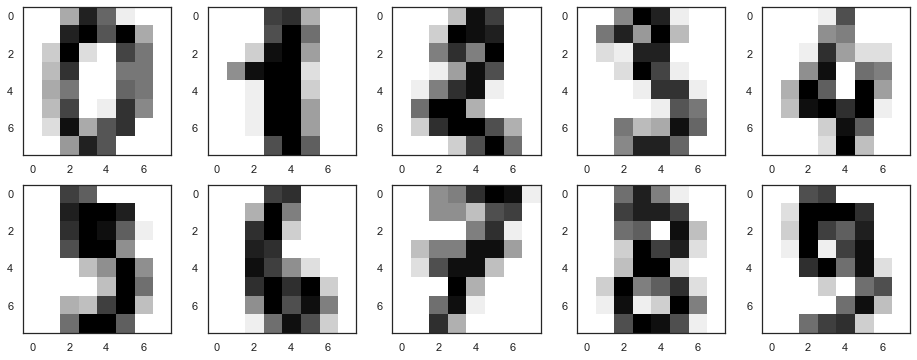

In [8]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='binary');

It turns out that the dimension of the feature space here is 64. But let's reduce the dimension to only 2 and see that even by eye, handwritten numbers are well divided into clusters.

Projecting 64-dimensional data to 2D
Wall time: 118 ms


Text(0.5, 1.0, 'MNIST. PCA projection')

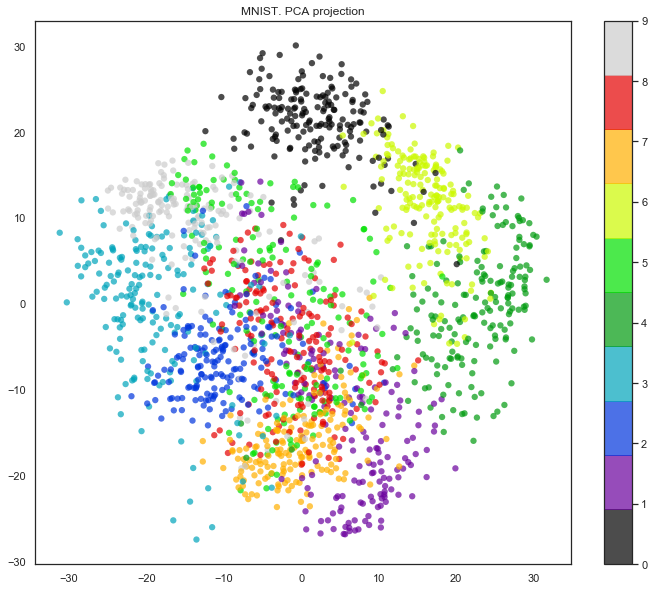

In [9]:
%%time
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Well, really, with t-SNE, the picture is even better, since PCA has a limitation - it finds only linear combinations of the original features. But even on this relatively small data set, you can see how much longer t-SNE works.

C:\Users\Alexander\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Alexander\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Wall time: 17.1 s


Text(0.5, 1.0, 'MNIST. t-SNE projection')

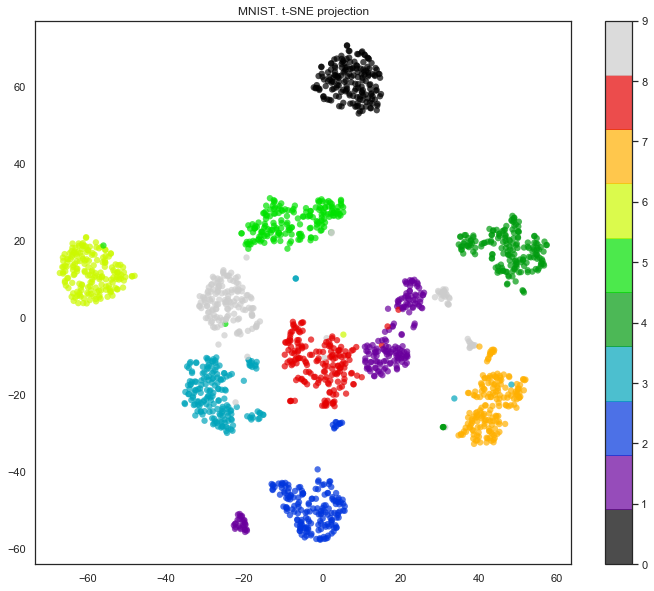

In [10]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

In practice, as a rule, so many principal components are chosen to leave 90% of the variance of the original data. In this case, for this it is enough to single out 21 main components, that is, to reduce the dimension from 64 features to 21.

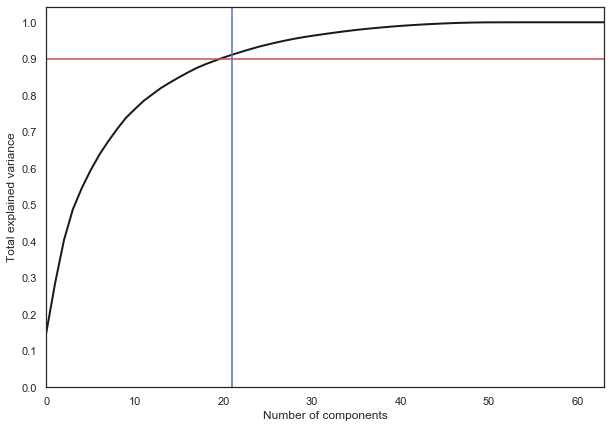

In [11]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

## 2. Clustering

The intuitive formulation of the clustering problem is quite simple and is our desire to say: “Here I have piled points. I see that they fall into some kind of piles together. It would be cool to be able to attribute these points to piles in the event of a new dots on the plane tell which heap it falls into." From such a statement it is clear that there is a lot of space for fantasy, and this gives rise to a corresponding set of algorithms for solving this problem. The listed algorithms by no means describe this set completely, but they are examples of the most popular methods for solving the clustering problem.

<figure><img align="center" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png"><figcaption>Examples of clustering algorithms from the documentation of the scikit-learn package</figcaption></figure>

### K-means

The K-means algorithm is probably the most popular and simplest clustering algorithm and is very easy to represent in simple pseudocode:
1. Choose the number of clusters that we think is optimal for our data.
2. Randomly pour points (centroids) into our data space $k$.
3. For each point in our data set, calculate which centroid it is closer to.
4. Move each centroid to the center of the sample that we assigned to this centroid.
5. Repeat the last two steps a fixed number of times, or until the centroids "converge" (usually this means that their displacement relative to the previous position does not exceed some predetermined small value).

In the case of the usual Euclidean metric for points lying on a plane, this algorithm is very simply written analytically and drawn. Let's see a relevant example:

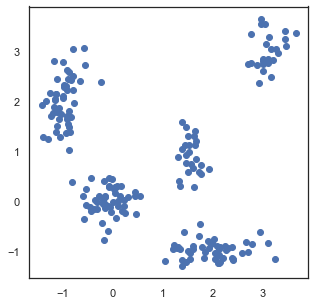

In [24]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((200, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

X[150:175, 0] = np.random.normal(loc=1.5, scale=.2, size=25)
X[150:175, 1] = np.random.normal(loc=1.0, scale=.5, size=25)

X[175:200, 0] = np.random.normal(loc=3.0, scale=.3, size=25)
X[175:200, 1] = np.random.normal(loc=3.0, scale=.3, size=25)


plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [25]:

from scipy.spatial.distance import cdist


np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(9):
    
    distances = cdist(X, centroids)
    
    labels = distances.argmin(axis=1)
    
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

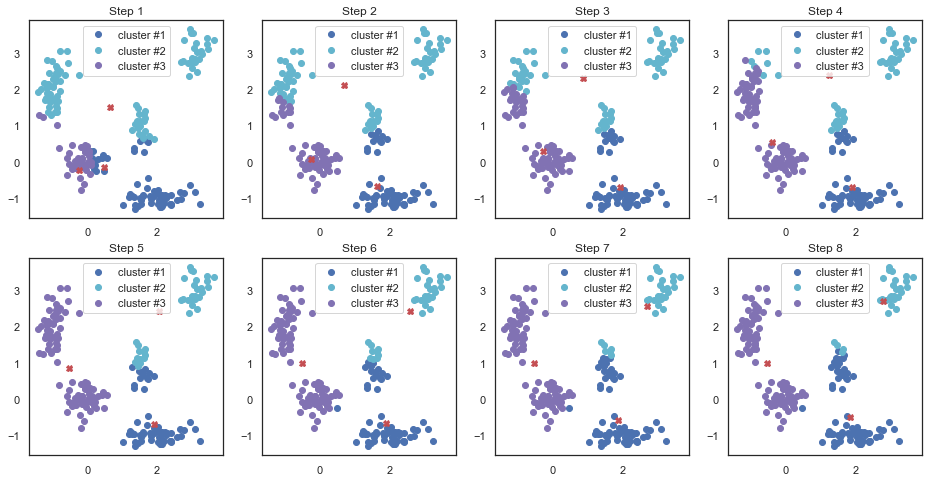

In [27]:

plt.figure(figsize=(16, 8))
for i in range(8):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 4, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

It is also worth noting that although we considered the Euclidean distance, the algorithm will converge in the case of any other metric, so for various clustering problems, depending on the data, you can experiment not only with the number of steps or the convergence criterion, but also with the metric by which we we calculate the distances between points and centroids of clusters.

Another feature of this algorithm is that it is sensitive to the initial position of the cluster centroids in space. In such a situation, it saves several successive runs of the algorithm, followed by averaging the resulting clusters.

## Select number of clusters for kMeans

In contrast to a classification or regression problem, in the case of clustering it is more difficult to choose a criterion by which it would be easy to represent the clustering problem as an optimization problem.
In the case of kMeans, such a criterion is common - the sum of the squared distances from points to the centroids of the clusters to which they belong.
$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

here $C$ is the set of clusters of size $K$, $\mu_k$ is the centroid of the cluster $C_k$.

It is clear that there is common sense in this: we want the points to be located in a heap near the centers of their clusters. But here's the problem: the minimum of such a functional will be achieved when there are as many clusters as there are points (that is, each point is a cluster of one element).
To solve this problem (choosing the number of clusters), the following heuristic is often used: one chooses the number of clusters, starting from which the described functional $ J(C) $ falls "not so fast". Or more formally:
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|} \rightarrow \min\ limits_k $$

Consider an example.

In [15]:
from sklearn.cluster import KMeans

In [16]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


C:\Users\Alexander\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


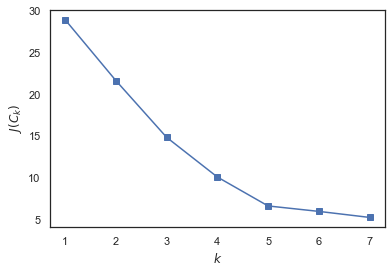

In [17]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

We see that $J(C_k)$ drops strongly as the number of clusters increases from 1 to 2 and from 2 to 3, and not so much as $k$ changes from 3 to 4. Hence, in this problem, it is optimal to specify 3 clusters.

By itself, the solution of the K-means problem is NP-hard, and for the dimension $d $, the number of clusters $k$ and the number of points $n$ is solved in $O(n^{d k+1})$. To solve such pain, heuristics are often used, for example, MiniBatch K-means, which does not use the entire dataset for training, but only its small portions (batch) and updates the centroids using the average over the entire history of centroid updates from all points related to it. A comparison of regular K-means and its MiniBatch implementation can be found in the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

[Implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm in scikit-learn has a lot of convenient features, such as the ability to set the number of runs through the `n_init` parameter, which will give more stable centroids for clusters in case of skewed data. In addition, these runs can be done in parallel without sacrificing computation time.

## Affinity Propagation

Another example of a clustering algorithm. Unlike the K-means algorithm, this approach does not require pre-determining the number of clusters into which we want to split our data. The basic idea of the algorithm is that we would like our observations to be clustered into groups based on how they "communicate" or how similar they are to each other.

For this, let's introduce some kind of "similarity" metric, defined by the fact that $s(x_i, x_j) > s(x_i, x_k)$ if observation $x_i$ is more similar to observation $x_j$ than to $x_k$. A simple example of such similarity would be the negative squared distance $s(x_i, x_j) = - ||x_i - x_j||^{2}$.

Now let's describe the process of "communication" itself, for this we will create two matrices initialized with zeros, one of which $r_{i,k}$ will describe how well the $k$-th observation is suitable for being a "role model" for $ i$-th observation, relative to all other potential "examples", and the second - $a_{i,k}$ will describe how correct it would be for $i$-th observation to choose $k$-th as such an "example" . It sounds a little confusing, but a little further we will see an example "on the fingers".

After that, the matrix data is updated in turn according to the rules:

$$r_{i,k} \leftarrow s_(x_i, x_k) - \max_{k' \neq k} \left\{ a_{i,k'} + s(x_i, x_k') \right\}$$

$$a_{i,k} \leftarrow \min \left( 0, r_{k,k} + \sum_{i' \not\in \{i,k\}} \max(0, r_{i',k}) \right), \ \ \  i \neq k$$

$$a_{k,k} \leftarrow \sum_{i' \neq k} \max(0, r_{i',k})$$

### Spectral clustering
Spectral clustering combines several approaches described above in order to get the maximum amount of profit from complex manifolds of dimension less than the original space.

For this algorithm to work, we need to define an observation similarity matrix (adjacency matrix). You can do it the same way as for Affinity Propagation above: $A_{i, j} = - ||x_i - x_j||^{2}$. This matrix also describes a complete graph with vertices in our observations and edges between each pair of observations with a weight corresponding to the degree of similarity of these vertices. For our above chosen metric and points lying on the plane, this thing will be intuitive and simple - two points are more similar if the edge between them is shorter. Now we would like to divide our resulting graph into two parts so that the resulting points in the two graphs are generally more similar to other points within the resulting "own" half of the graph than to points in the "other" half. The formal name of such a problem is called the Normalized cuts problem and you can read more about it [here] (http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

## Agglomerative (Hierarchical) clustering


Probably the simplest and most understandable clustering algorithm without a fixed number of clusters is agglomerative clustering. The intuition of the algorithm is very simple:
1. We start by pouring our own cluster on each point
2. Sort pairwise distances between cluster centers in ascending order
3. Take a couple of nearest clusters, glue them into one and recalculate the center of the cluster
4. Repeat steps 2 and 3 until all data is glued into one cluster

The process of searching for the nearest clusters can take place using different methods of combining points:
1. Single linkage - minimum pairwise distances between points from two clusters
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage - maximum pairwise distances between points from two clusters
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage - the average of pairwise distances between points from two clusters
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage - the distance between the centroids of two clusters
$d(C_i, C_j) = ||\mu_i - \mu_j||$

The advantage of the first three approaches compared to the fourth is that they will not need to recalculate the distances every time after gluing, which greatly reduces the computational complexity of the algorithm.

Based on the results of such an algorithm, we can also build a wonderful cluster gluing tree and, looking at it, determine at what stage it would be best for us to stop the algorithm. Or use the same elbow rule as in k-means.

Luckily for us, python already has great tools for building such dendrograms for agglomerative clustering. Consider our clusters from K-means as an example:

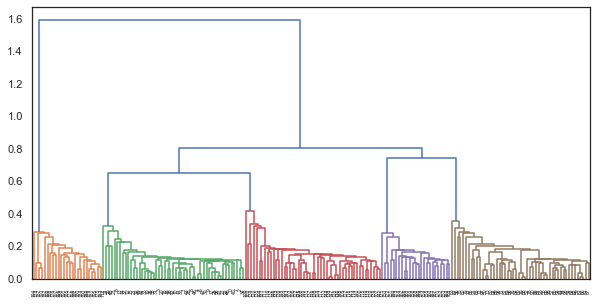

In [18]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# X = np.zeros((150, 2))

# np.random.seed(seed=42)
# X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
# X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

# X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
# X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

# X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
# X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

distance_mat = pdist(X) 

Z = hierarchy.linkage(distance_mat, 'single') 
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

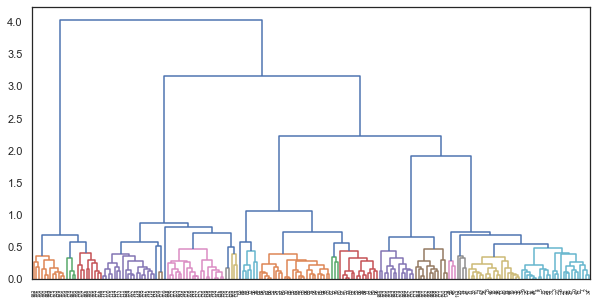

In [19]:
Z = hierarchy.linkage(distance_mat, 'average') 
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

## Clustering quality metrics
The task of assessing the quality of clustering is more complex than assessing the quality of classification. First, such estimates should not depend on the label values themselves, but only on the sample split itself. Secondly, the true labels of objects are not always known, so estimates are also needed to assess the quality of clustering using only an unlabeled sample.

There are *external* and *internal* quality metrics. External metrics use information about the true clustering, while internal metrics do not use any external information and evaluate the quality of clustering based only on the data set. The optimal number of clusters is usually determined using internal metrics.

All of the metrics below are implemented in `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

It is assumed that the true labels of the objects are known. This measure does not depend on the label values themselves, but only on the division of the sample into clusters. Let $N$ be the number of objects in the sample. Let us denote by $a$ the number of pairs of objects that have the same labels and are in the same cluster, by $b$ the number of pairs of objects that have different labels and are in different clusters. Then Rand Index is $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$ ) are "agreed". Rand Index (RI) expresses the similarity of two different clusterings of the same sample. For this index to give values close to zero for random clusterings for any $N$ and number of clusters, it is necessary to normalize it. This is how the Adjusted Rand Index is defined: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI} ]}.$$

This measure is symmetrical and does not depend on the values and permutations of labels. Thus, this index is a measure of the distance between different partitions of the sample. $\text{ARI}$ takes values in the range $[-1, 1]$. Negative values correspond to "independent" partitions into clusters, values close to zero correspond to random partitions, and positive values indicate that the two partitions are similar (coincide when $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

This measure is very similar to $\text{ARI}$. It is also symmetric and does not depend on the values and permutations of labels. Defined using the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) function, interpreting the sample splits as discrete distributions (the probability of being assigned to a cluster is equal to the proportion of objects in it). The $MI$ index is defined as [mutual information](https://en.wikipedia.org/wiki/Mutual_information) for two distributions corresponding to sample clusterings Intuitively, mutual information measures the fraction of information shared by both partitions: how much information about one of them reduces uncertainty relative to the other.

Similarly to $\text{ARI}$, the $\text{AMI}$ index is defined, which makes it possible to get rid of the growth of the $MI$ index with an increase in the number of classes. It takes values in the range $[0, 1]$. Values close to zero indicate the independence of the partitions, and values close to one indicate their similarity (coincidence at $\text{AMI} = 1$).

**Homogeneity, completeness, V-measure**

Formally, these measures are also defined using entropy and conditional entropy functions, considering sample partitions as discrete distributions: $$h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac {H(K\mid C)}{H(K)},$$
here $K$ is the result of clustering, $C$ is the true division of the sample into classes. Thus, $h$ measures how much each cluster consists of objects of the same class, and $c$ measures how much objects of the same class belong to the same cluster. These measures are not symmetrical. Both values take values in the range $[0, 1]$, and larger values correspond to more accurate clustering. These measures are not normalized like $\text{ARI}$ or $\text{AMI}$ and therefore depend on the number of clusters. Random clustering will not give zero values for a large number of classes and a small number of objects. In these cases it is preferable to use $\text{ARI}$. However, when the number of objects is more than 1000 and the number of clusters is less than 10, this problem is not so pronounced and can be ignored.

To take into account both quantities $h$ and $c$, the $V$-measure is simultaneously introduced as their harmonic mean:
$$v = 2\frac{hc}{h+c}.$$
It is symmetrical and shows how similar two clusterings are to each other.

**Silhouette**

Unlike the metrics described above, this coefficient does not imply knowledge of the true labels of objects, and allows you to evaluate the quality of clustering using only the (unlabeled) sample itself and the result of clustering. First, the silhouette is defined separately for each object. Let us denote by $a$ the average distance from a given object to objects from the same cluster, by $b$ the average distance from a given object to objects from the nearest cluster (other than the one in which the object itself is located). Then the silhouette of this object is the value: $$s = \frac{b - a}{\max(a, b)}.$$
The silhouette of a sample is the average value of the silhouette of objects in a given sample. Thus, the silhouette shows how the average distance to objects in its cluster differs from the average distance to objects in other clusters. This value lies in the range $[-1, 1]$. Values close to -1 correspond to bad (scattered) clusterings, values close to zero indicate that the clusters intersect and overlap each other, values close to 1 correspond to "dense" well-defined clusters. Thus, the larger the silhouette, the more clearly defined clusters, and they are compact, densely clustered point clouds.

Using the silhouette, you can choose the optimal number of clusters $k$ (if it is not known in advance) - the number of clusters that maximizes the value of the silhouette is chosen. Unlike the previous metrics, the silhouette depends on the shape of the clusters, and reaches large values on more convex clusters obtained using algorithms based on the restoration of the distribution density.

Finally, let's look at these metrics for our algorithms running on MNIST handwritten digit data:

In [20]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.662295,0.736567,0.735448,0.742972,0.739191,0.182097
Affinity,0.174985,0.612399,0.958901,0.486837,0.645800,0.115159
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497
